# Project 3: Wrangle OpenStreetMap Data
---
*Dieter Annys*

> This is the coding part of the project

> Explanation and details can be fount in the accompanying report
 

In [1]:
# Imports
import xml.etree.cElementTree as ET
from pprint import pprint as pp
import os, sqlite3, re

In [2]:
# Map extract file
file = 'medellin_colombia.osm'

In [3]:
# Checking the file size
print("File Size: {:.3f} MB".format(os.path.getsize(file)/(1024.0**2)))

File Size: 76.349 MB


## 1. Generate Reference Dict

In [4]:
%%time
'''
The following code generates a dictionary to use later in the notebook for analyzing the values
- elements: will contain element tags and how often they occur
- tag_keys: will contain all unique tag keys, each containing how often they occur, and a set of their unique values
'''
elements = dict()
tag_keys = dict()
attribs = {a: set() for a in ["node", "way", "tag", "nd"]}

# Set to True to limit amount of results
limit = False
i = 10000

# Helper function to store values per key
def collect_in_dict(d, t):
    k = t.attrib["k"]
    v = t.attrib["v"]
    if k in d.keys():
        d[k]["count"] += 1
        d[k]["values"].add(v)
    else:
        d[k] = {}
        d[k]["count"] = 1
        d[k]["values"] = {v}
    return d
    
# Iterate over the XML elementtree and generate the dicts
for event, elem in ET.iterparse(file):
    
    # Collect element tag information
    if elem.tag in elements.keys():
        elements[elem.tag] += 1
    else:
        elements[elem.tag] = 1
        
    # Collect element attribute names
    if elem.tag in attribs.keys():
        for attrib in elem.attrib:
            attribs[elem.tag].add(attrib)
    
    # Collect node tag keys information
    if elem.tag in ["node", "way"]:
        for tag in elem.findall('tag'):
            tag_keys = collect_in_dict(tag_keys, tag)
    
    # For limiting output
    if limit:
        if i <= 0:
            break
        else:
            i -= 1
        
# Printing the collected data
print("Element Tags:")
print(elements)
print("\nElement Attributes:")
pp(attribs)
print("\nNode & WayTag Keys:")
# , key=node_tag_keys.get, reverse=True
for k in sorted(tag_keys):
    print(' - {} ({}x)'.format(k, tag_keys[k]["count"]))
print("\n")

Element Tags:
{'bounds': 1, 'node': 382257, 'tag': 114746, 'nd': 449013, 'way': 41450, 'member': 6450, 'relation': 1549, 'osm': 1}

Element Attributes:
{'nd': {'ref'},
 'node': {'changeset',
          'id',
          'lat',
          'lon',
          'timestamp',
          'uid',
          'user',
          'version'},
 'tag': {'v', 'k'},
 'way': {'user', 'changeset', 'id', 'timestamp', 'version', 'uid'}}

Node & WayTag Keys:
 - Direccion (1x)
 - FIXME (2x)
 - Municipio (1x)
 - _ID (2x)
 - access (909x)
 - addr:city (538x)
 - addr:country (52x)
 - addr:floor (2x)
 - addr:full (76x)
 - addr:housename (52x)
 - addr:housenumber (507x)
 - addr:place (10x)
 - addr:postcode (125x)
 - addr:province (2x)
 - addr:state (8x)
 - addr:street (694x)
 - admin_level (128x)
 - aerialway (65x)
 - aerialway:bubble (2x)
 - aerodrome (1x)
 - aeroway (145x)
 - airmark (1x)
 - airport_ident (1x)
 - alt_name (557x)
 - amenity (2251x)
 - area (158x)
 - artist_name (9x)
 - artwork_type (9x)
 - atm (25x)
 - aut

## 2. Audit Values & Define Update Functions

### Values for Curious Looking Keys

In [5]:
# Values for Direccion, Municipio, direction
for k in ["Direccion", "Municipio", "direction"]:
    print(k, tag_keys[k]["values"])

Direccion {'Calle 29sur'}
Municipio {'Envigado'}
direction {'backward', 'forward', 'anticlockwise'}


### Values for addr:street

In [6]:
def audit_street(addr_street, print_bad=False):
    expected = ["Avenida", "Calle", "Carrera", "Diagonal", "Transversal", "Circular"]
    # Regex pattern: Any of the expected street types followed by a number and maybe 1 or 2 series of letters
    street_pattern = re.compile("^(" + "|".join(expected) + ")\s\d{1,3}(\s?\w{1,3}){0,2}$")
    m = street_pattern.match(addr_street)
    if print_bad and not m:
        print(addr_street)
    return m != None


audits = [
    audit_street(addr_street) 
    for addr_street in sorted(tag_keys["addr:street"]["values"])]
print(len([t for t in audits if t]), "good values of", len(audits), "total")

235 good values of 362 total


In [7]:
# Generic function that takes a value and a mapping, and returns the value with replacements made
def map_values(value, mapping):
    for k, v in mapping.items():
        pattern = re.compile(v, re.IGNORECASE)
        value = re.sub(pattern, k, value)
    return value

# Function that updates the street type. Input: addr:street, Return: corrected addr:street
def update_street_type(addr_street):
    mapping = {
        'Calle ': '^(c(al)?le?\s|cll)',
        'Carrera ': '^(c(arre)?ra|cr)\s?'
    }
    return map_values(addr_street, mapping)
    
audits = [
    audit_street(update_street_type(addr_street)) 
    for addr_street in sorted(tag_keys["addr:street"]["values"])]
print(len([t for t in audits if t]), "good values of", len(audits), "total")

245 good values of 362 total


In [8]:
# Function that splits the street if it contains a number. Input: addr:street, Return:
def update_split_str_nr(addr_street):
    pattern = re.compile('\s?(#|No\.?(\s|\d))\s?')
    splitted = re.split(pattern, addr_street)
    if len(splitted) > 1:
        return splitted[0], splitted[2]
    return splitted[0], None
    
audits = [
    audit_street(update_split_str_nr(update_street_type(addr_street))[0], print_bad=True)
    for addr_street in sorted(tag_keys["addr:street"]["values"])]
print(len([t for t in audits if t]), "good values of", len(audits), "total")


17B Sur
32-118
36A
39
46
51
53c
54
54 B 06 Interior 201
55
55g
61
74 79
97
Acceso a Girardota
Autopista Bogotá
Autopista Medellín-Bogotá
Autopista Norte, Calle 46
Autopista Sur
Avenida El Poblado
Avenida El Poblado;Carrera 43A
Avenida Las Vegas
Avenida Nutibara
Avenida Nutibara;Transversal 39B
Avenida del Ferrocarril
Ayacucho
Calle
Calle 12 Sur / Los Balsos
Calle 25 Sur 42 - 73
Calle 41;Los Huesos
Calle 48 C Sur 42 A - 80
Calle 48;Pichincha
Calle 49 x Carrera 49
Calle 50; Colombia
Calle 50;Colombia
Calle 53;Maracaibo
Calle 54;Juanambú
Calle del Banco
Carabobo
Carrera 
Carrera 43 A con Calle 7
Carrera 45;El Palo
Carrera 50;Palacé
Carrera 52; Avenida Guayabal
Carrera 52;Avenida Guayabal
Carrera 52;Carabobo
Carrera 70, 40
Carrera 89 N 42 C
Centro Comercial Veracruz
Doble calzada Niquia - Hatillo
Glorieta Colombia con Avenida 80
Kilometro 8
La Peréz
Las Palmas
Loma del Escobero
N 55 - 240
Palenque
Salida Carrera 43 A
Salida a Autopista Sur
Salida a Calle 10
Salida a Carrera 65
Tenerife
Tr

### Values for addr:city

In [9]:
import unicodedata

def update_remove_accents(value):
    value = unicodedata.normalize('NFKD', value).encode('ASCII', 'ignore')
    value = value.decode("utf-8")
    return value

def update_city(city):
    city = str(city).replace(",", "").strip()
    city = city.split()
    for i, word in enumerate(city):
        city[i] = word[0].upper() + word[1:].lower()
    city = " ".join(city)
    city_mapping = {
        "Medellin": "^medell?i|^el\spoblado|^comuna",
        "Rio Negro": "^rio\s?negro",
        "Sabaneta": "^sabaneta",
        "La Ceja del Tambo": "^la\sceja",
        "El Carmen de Viboral": "^el\scarmen\sde\svibora"
    }
    for correct, regex in city_mapping.items():
        pattern = re.compile(regex, re.I)
        m = re.search(pattern, city)
        if m:
            city = correct
            break
    return city

cities = {update_city(update_remove_accents(city)) for city in tag_keys["addr:city"]["values"]}
print(len(cities))
pp(cities)

18
{'Angelopolis',
 'Bello',
 'Copacabana',
 'Donmatias',
 'Ebejico',
 'El Carmen de Viboral',
 'El Retiro',
 'Envigado',
 'Girardota',
 'Itagui',
 'La Ceja del Tambo',
 'La Estrella',
 'Marinilla',
 'Medellin',
 'Rio Negro',
 'Sabaneta',
 'San Vicente',
 'Santa Fe De Antioquia'}


## 3. Export Data to CSV

In [10]:
dict_csv = {
    "node": list(),
    "node_tag": list(),
    "way": list(),
    "way_tag": list(),
    "way_node": list()
}

for event, elem in ET.iterparse(file):
    if elem.tag == "node" or elem.tag == "way":
        
        # Since there is no mapping to be done, simply pass the node and way attributes to the dict
        dict_csv[elem.tag].append(elem.attrib)
        
        # Get parent type and id for the tags and way nodes
        parent_type = elem.tag
        parent_id = elem.attrib["id"]
        
        # Process tag elements
        for tag in elem.findall('tag'):
            # Putting tag in a list, because later when splitting the tag, multiple records will be added
            tags_to_add = [
                {
                    "type_key": tag.attrib["k"].split(":", 1),
                    "value": tag.attrib["v"]
                }
            ]
            if len(tags_to_add[0]["type_key"]) > 1:
                tags_to_add[0]["type"] = tags_to_add[0]["type_key"][0]
            else:
                tags_to_add[0]["type"] = ""
            tags_to_add[0]["key"] = tags_to_add[0]["type_key"][-1]
            
            # Pass keys and values through update functions
            
            # UPDATE: remove all accents from values
            tags_to_add[0]["value"] = update_remove_accents(tags_to_add[0]["value"])
            
            # UPDATE: change the Direccion and Municipio key names
            change_key_names = {
                "Direccion": ["addr", "street"],
                "Municipio": ["addr", "city"]
            }
            if tags_to_add[0]["key"] in change_key_names:
                tags_to_add[0]["type"], tags_to_add[0]["key"] = change_key_names[tags_to_add[0]["key"]]
            
            # UPDATE: split addr:full and if necessary addr:street in street & nr
            if tags_to_add[0]["type"] == 'addr' and tags_to_add[0]["key"] in ["street", "full"]:
                street, nr = update_split_str_nr(tags_to_add[0]["value"])
                tags_to_add[0]["key"] = "street"
                tags_to_add[0]["value"] = street
                if nr != None:
                    tags_to_add.append({
                        "value": "housenumber",
                        "key": nr,
                        "type": "addr"
                    })
            # UPDATE: Set all state/province keynames to state, values to Antioquia
            elif tags_to_add[0]["type"] == 'addr' and tags_to_add[0]["key"] in ["province", "state"]:
                tags_to_add[0]['key'] = "state"
                tags_to_add[0]['value'] = "Antioquia"
            
            # UPDATE: process street type
            for tag in tags_to_add:
                if tag["type"] == 'addr' and tag["key"] == "street":                    
                    tag["value"] = update_street_type(tag["value"])
            # UPDATE: city names
                if tag["type"] == 'addr' and tag["key"] == "city": 
                    tag["value"] = update_city(tag["value"])
                    cities.add(tag["value"])
                    
            
            
            # Put the values in dict_csv for later exporting
            for tag in tags_to_add:
                dict_csv[parent_type + "_tag"].append({
                    "id": parent_id,
                    "type": tag['type'],
                    "key": tag['key'],
                    "value": tag['value']
                })
        
        # Process way node elements
        nd_pos = 0
        for nd in elem.findall('nd'):
            dict_csv[parent_type + "_node"].append({
                "id": parent_id,
                "node_id": nd.attrib["ref"],
                "position": nd_pos
            })
            nd_pos += 1

In [11]:
# Export dict_csv to CSV
import unicodecsv

# Define fieldnames so that values get exported in same order as db schema
fieldnames = {
    "node": ["id", "lat", "lon", "user", "uid", "version", "changeset", "timestamp"],
    "node_tag": ["id", "key", "value", "type"],
    "way": ["id", "user", "uid", "version", "changeset", "timestamp"],
    "way_tag": ["id", "key", "value", "type"],
    "way_node": ["id", "node_id", "position"],
}

for coll in dict_csv.keys():
    with open(coll + '.csv', 'wb') as f:
        writer = unicodecsv.DictWriter(f, fieldnames=fieldnames[coll])
        # Not writing header, or else SQLite will try to import it as values
#         writer.writeheader()
        for row in dict_csv[coll]:
            writer.writerow(row)

## 4. Import CSVs to SQLite Database

In [12]:
dbfile = 'medellin_osm.db'

# Starting from scratch, first removing the db if it exists
if os.path.exists(dbfile):
    os.remove(dbfile)

# Connecting to the db and creating the tables according to provided schema
db = sqlite3.connect(dbfile)
c = db.cursor()
with open('data_wrangling_schema.sql') as f:
    queries = f.read().split(';')
for query in queries:
    c.execute(query.strip() + ";")
db.commit()

db.close()

Importing happens in the console. The commands were placed in a file called import_csv.sql for convenience

    > sqlite3 medellin_osm.db
    > .mode csv
    > .import node.csv nodes
    > .import node_tag.csv nodes_tags
    > .import way.csv ways
    > .import way_node.csv ways_nodes
    > .import way_tag.csv ways_tags

## 5. Investigative Queries on the Database
This is done in the shell, and is further documented in the report

## Additional

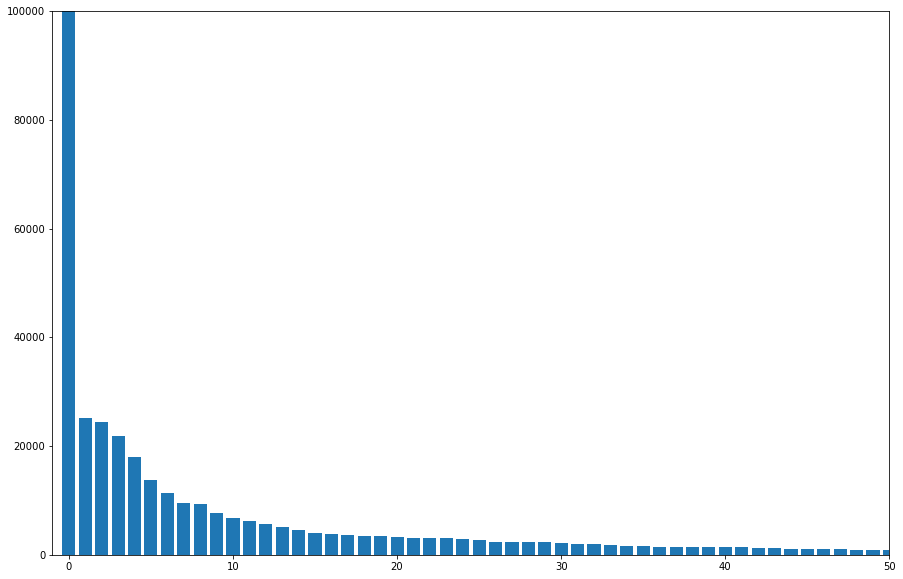

In [15]:
%matplotlib inline
# Plot of users and the amount of their individual contribution
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('user_count.csv', header=None)
plt.rcParams['figure.figsize'] = (15,10)
plt.xlim(-1,50)
plt.ylim(0,100000)
x = list(range(len(data[1])))
plt.bar(x, data[1])
plt.savefig('name_count.png')

In [14]:
# File sizes
for filename in ["medellin_colombia.osm",
                "sample.osm",
                "medellin_osm.db",
                "node.csv",
                "node_tag.csv",
                "way.csv",
                "way_tag.csv",
                "way_node.csv"]:
    print(filename, "." * (25-len(filename)), "{:.2f}".format(os.path.getsize(filename)/(1024.0**2)), "MB")

medellin_colombia.osm .... 76.35 MB
sample.osm ............... 5.19 MB
medellin_osm.db .......... 39.35 MB
node.csv ................. 30.03 MB
node_tag.csv ............. 0.90 MB
way.csv .................. 2.37 MB
way_tag.csv .............. 2.18 MB
way_node.csv ............. 10.40 MB
